# Creation of a baseline model
This is just the baseline model again, but now it uses SMOTE.

## Pipeline

In [23]:
import os
import pandas as pd

# mögliche Modelle zur Klassifikation: SVM, Random Forest, LogisticRegression, KNearestNeighbor
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


# there are only binary values for the nominal columns
nominal_cols = [
    "HighBP",
    "HighChol",
    "CholCheck",
    "Smoker",
    "Stroke",
    "HeartDiseaseorAttack",
    "PhysActivity",
    "Fruits",
    "Veggies",
    "HvyAlcoholConsump",
    "AnyHealthcare",
    "NoDocbcCost",
    "DiffWalk",
    "Sex",
]
nominal_pipe = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first")),
    ]
)

ordinal_cols = ["GenHlth", "Age", "Education", "Income"]

ordinal_orders = {
    "GenHlth": list(range(1, 6)),
    "Age": list(range(1, 14)),
    "Education": list(range(1, 7)),
    "Income": list(range(1, 9)),
}

ordinal_categories = [ordinal_orders[col] for col in ordinal_cols]

ordinal_pipe = Pipeline(
    [
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("encode", OrdinalEncoder(categories=ordinal_categories)),
    ]
)


numeric_cols = ["BMI", "MentHlth", "PhysHlth"]
num_pipe = Pipeline(
    [("impute", SimpleImputer(strategy="median")), ("scale", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_cols),
        ("ord", ordinal_pipe, ordinal_cols),
        ("nom", nominal_pipe, nominal_cols),
    ],
    remainder="drop",
)

df_train_raw = pd.read_csv(os.path.join("..", "data", "split", "train_raw_split.csv"))
df_train_raw = df_train_raw[df_train_raw["Diabetes_012"] != 0]
features_train_raw = df_train_raw.drop("Diabetes_012", axis=1)
target_train_raw = pd.to_numeric(df_train_raw["Diabetes_012"])

classifier = RandomForestClassifier(class_weight="balanced")

pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("smote", SMOTE(sampling_strategy="minority", random_state=42)),
        ("classifier", classifier),
    ]
)


## Training

In [24]:
%%time
from datetime import datetime

pipeline.fit(features_train_raw, target_train_raw)


timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

CPU times: total: 7.12 s
Wall time: 6.68 s


## Prediction

In [25]:
df_val = pd.read_csv(os.path.join("..", "data", "split", "validation_raw_split.csv"))
df_val = df_val[df_val["Diabetes_012"] != 0] 
features_val = df_val.drop("Diabetes_012", axis=1)
target_val = pd.to_numeric(df_val["Diabetes_012"])

target_val_pred = pipeline.predict(features_val)

## Evaluation

### Metrics

In [ ]:
from sklearn.metrics import (
    f1_score,
    recall_score,
    precision_score,
    balanced_accuracy_score,
    confusion_matrix,
    classification_report,
)

avg_mode = "weighted"
precision_score_val = precision_score(target_val, target_val_pred, average=avg_mode)
recall_score_val = recall_score(target_val, target_val_pred, average=avg_mode)
f1_score_val = f1_score(target_val, target_val_pred, average=avg_mode)
balanced_accuracy_val = balanced_accuracy_score(target_val, target_val_pred)
confusion_matrix_val = confusion_matrix(target_val, target_val_pred)

conf_m = confusion_matrix_val.ravel()

print("precision:", precision_score_val)
print("F1:", f1_score_val)
print("bal acc:", balanced_accuracy_val)

baseline_results = {
    "timestamp": timestamp,
    "model_purpose": "baseline",
    "model": classifier.__class__.__name__,
    "special_features": "SMOTE minority no healthy",
    "avg_mode": avg_mode,
    "f1": f1_score_val,
    "recall": recall_score_val,
    "precision": precision_score_val,
    "bal. accuracy": balanced_accuracy_val,
    "conf_matrix": {
        f"C_{true_class}_{pred_class}": int(
            confusion_matrix_val[true_class, pred_class]
        )
        for true_class in list(range(confusion_matrix_val.shape[0]))
        for pred_class in list(range(confusion_matrix_val.shape[1]))
    },
    "classification_report": classification_report(
        target_val, target_val_pred, digits=3, output_dict=True
    ),
}
print()
print("confusion_matrix")
labels = sorted(target_val.unique())
print("Pred→ " + "  ".join(f"{lab:>5}" for lab in labels))
for i, row in enumerate(confusion_matrix_val):
    row_str = " ".join(f"{v:5}" for v in row)
    print(f"True {labels[i]:<2}: {row_str}")

print()
print("classification_report")
print(classification_report(target_val, target_val_pred, digits=3))

precision: 0.8022252918393327
F1: 0.8242550714869081
bal acc: 0.5078507558015755

confusion_matrix
Pred→   1.0    2.0
True 1.0:    14   474
True 2.0:    46  3496

classification_report
              precision    recall  f1-score   support

         1.0      0.233     0.029     0.051       488
         2.0      0.881     0.987     0.931      3542

    accuracy                          0.871      4030
   macro avg      0.557     0.508     0.491      4030
weighted avg      0.802     0.871     0.824      4030



### Learning Curve

In [28]:
%%time
from sklearn.model_selection import learning_curve
import numpy as np

preprocessed_features_train_raw = preprocessor.fit_transform(features_train_raw)

scoring_mode = "precision_macro"

train_sizes, train_scores, val_scores = learning_curve(
    estimator=classifier,
    X=preprocessed_features_train_raw,
    y=target_train_raw,
    cv=5,
    scoring=scoring_mode,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

CPU times: total: 406 ms
Wall time: 18 s


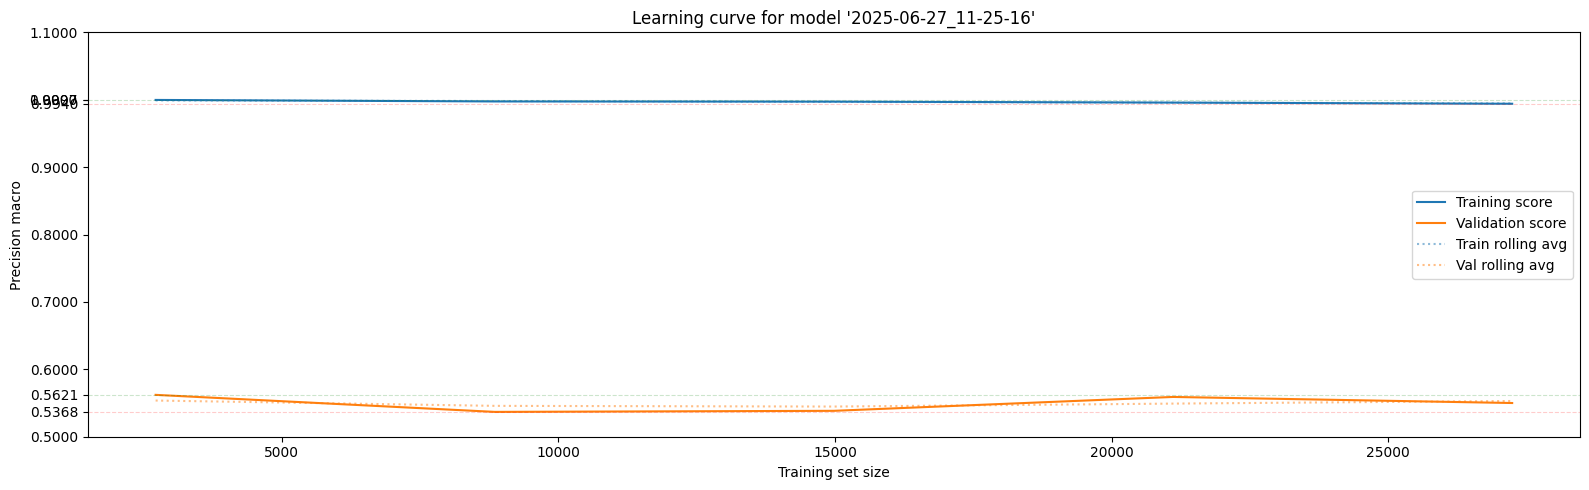

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import io
from scipy.ndimage import uniform_filter1d


fig, ax = plt.subplots(figsize=(16, 5))

# Hauptlinien
train_line, = ax.plot(train_sizes, train_mean, label="Training score")
val_line, = ax.plot(train_sizes, val_mean, label="Validation score")

# Farben extrahieren
train_color = train_line.get_color()
val_color = val_line.get_color()

# Min-/Max-Werte
y_lines_min = [train_mean.min(), val_mean.min()]
y_lines_max = [train_mean.max(), val_mean.max()]

# Hilfslinien
for y in y_lines_min:
    ax.axhline(y, color="red", linestyle="--", linewidth=0.8, alpha=0.2)
for y in y_lines_max:
    ax.axhline(y, color="green", linestyle="--", linewidth=0.8, alpha=0.2)

# Rollender Durchschnitt (Fenstergröße = 3)
train_rolling = uniform_filter1d(train_mean, size=3, mode="nearest")
val_rolling = uniform_filter1d(val_mean, size=3, mode="nearest")

ax.plot(train_sizes, train_rolling, label="Train rolling avg", linestyle=":", linewidth=1.5, color=train_color, alpha=0.5)
ax.plot(train_sizes, val_rolling, label="Val rolling avg", linestyle=":", linewidth=1.5, color=val_color, alpha=0.5)

# y-Ticks
yticks = sorted(set(ax.get_yticks().tolist() + y_lines_min + y_lines_max))
ax.set_yticks(yticks)

ax.set_xlabel("Training set size")
ax.set_ylabel(scoring_mode.replace("_", " ").capitalize())

ax.set_title(f"Learning curve for model '{baseline_results["timestamp"]}'")

ax.legend()
fig.tight_layout()
learning_curve_img = io.BytesIO()
fig.savefig(learning_curve_img, format="png")
learning_curve_img.seek(0)
plt.show()


### Feature Importances

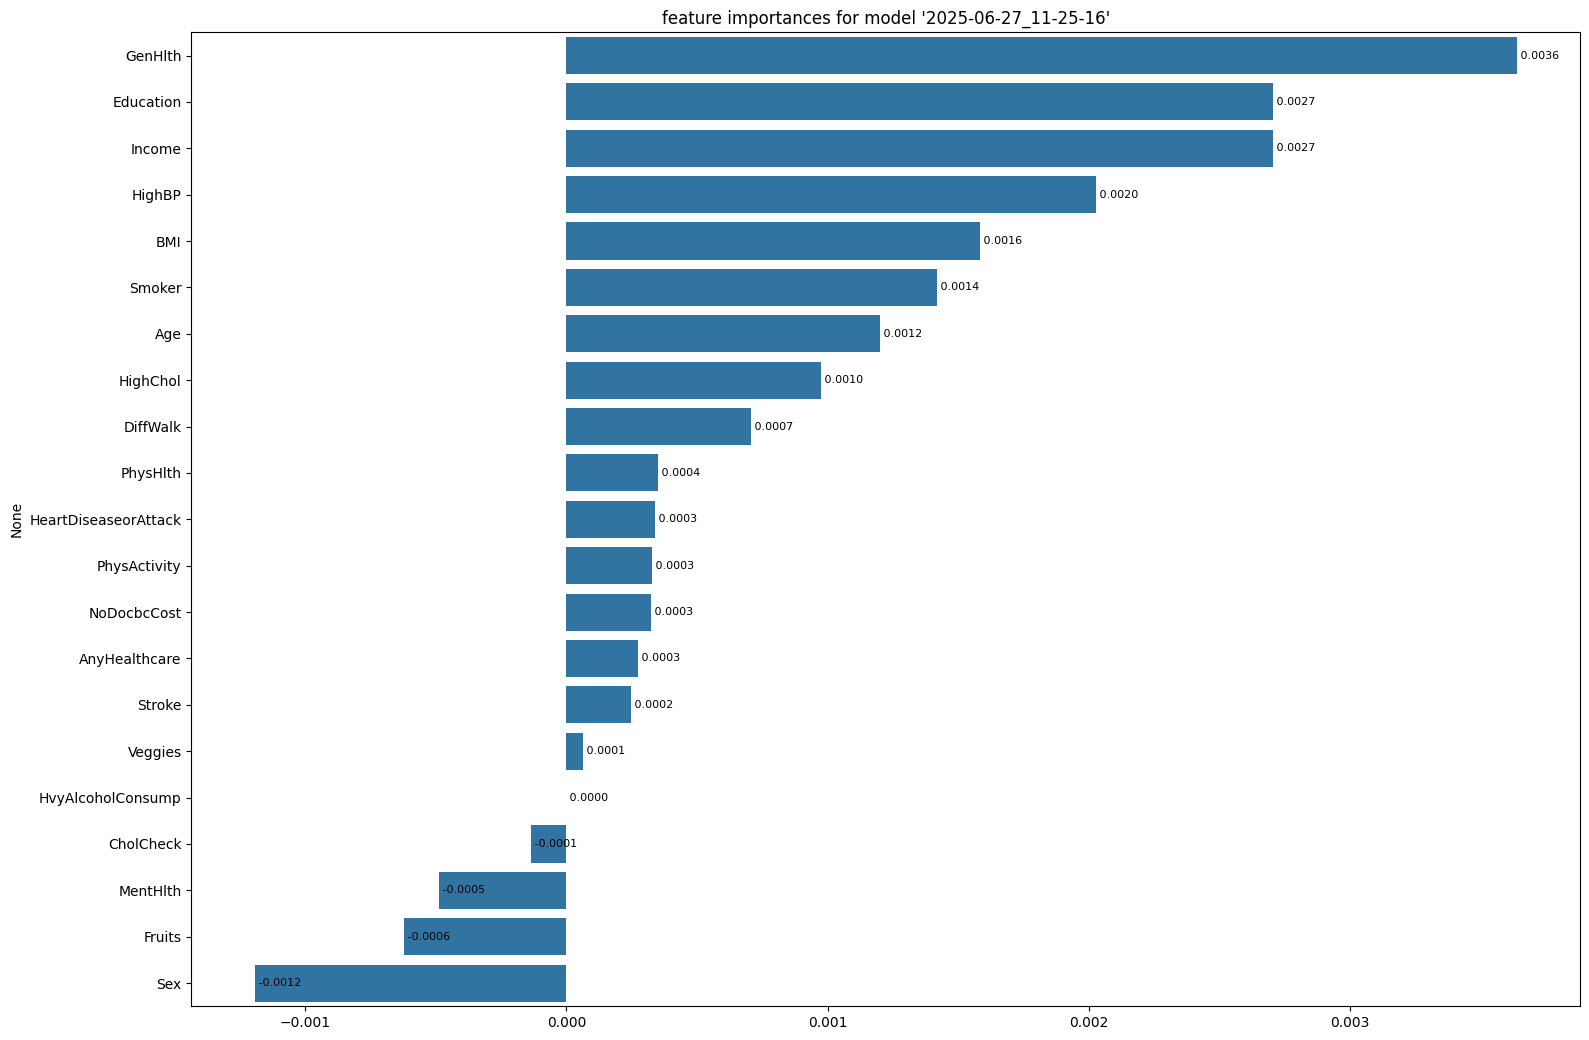

In [30]:
import seaborn as sns

preprocessed_features_val = preprocessor.transform(features_val)
target_val_pred = classifier.predict(preprocessed_features_val)

f1_orig = f1_score(target_val, target_val_pred, average="weighted")

perm_importances = []
for feat in features_val.columns:
    features_perm = features_val.copy()
    run_perm_imps = []
    # Permutation importance: shuffle the feature and measure the decrease in performance
    for i in range(5):
        series_perm = features_perm[feat].sample(frac=1, replace=False, random_state=i)
        series_perm.reset_index(drop=True, inplace=True)
        features_perm[feat] = series_perm

        preprocessed_features_fimp = preprocessor.transform(features_perm)
        f1_perm = f1_score(
            target_val,
            classifier.predict(preprocessed_features_fimp),
            average="weighted",
        )
        run_perm_imps.append(f1_orig - f1_perm)
    perm_importances.append(np.mean(run_perm_imps))

feature_importances = pd.Series(data=perm_importances, index=features_val.columns)
feature_importances.sort_values(ascending=False, inplace=True)


fig, ax = plt.subplots(figsize=(16, 0.5 * len(features_val.columns)))
sns.barplot(x=feature_importances.values, y=feature_importances.index, ax=ax)
ax.set_title(f"feature importances for model '{baseline_results['timestamp']}'")
for i, (val, label) in enumerate(
    zip(feature_importances.values, feature_importances.index)
):
    ax.text(val, i, f" {val:.4f}", va="center", ha="left", fontsize=8)

fig.tight_layout()
feature_importances_img = io.BytesIO()
fig.savefig(feature_importances_img, format="png")
feature_importances_img.seek(0)
plt.show()

### Save

In [31]:
################################################################################
### Save the model
import pickle
import json
import os

folder = os.path.join("..", "models", baseline_results["timestamp"])
filename = os.path.join(folder, baseline_results["timestamp"])
os.makedirs(folder, exist_ok=True)

with open(f"{filename}.model.pkl", "wb") as f:
    pickle.dump(classifier, f)

with open(f"{filename}.pipeline.pkl", "wb") as f:
    pickle.dump(preprocessor, f)

with open(f"{filename}.model.txt", "w") as file:
    file.write(str(classifier))

with open(f"{filename}.results.json", "w") as f:
    json.dump(baseline_results, f, indent=2)

with open(f"{filename}.pipeline_params.txt", "w") as f:
    f.write(preprocessor.get_params().__str__())

with open(f"{filename}.model_params.json", "w") as f:
    json.dump(classifier.get_params(), f, indent=2)

if learning_curve_img and not learning_curve_img.closed:
    with open(f"{filename}.learning_curve_img.png", "wb") as f:
        f.write(learning_curve_img.getvalue())
    learning_curve_img.close()
else:
    print("No learning curve to save available")

if feature_importances_img and not feature_importances_img.closed:
    with open(f"{filename}.feature_importances.png", "wb") as f:
        f.write(feature_importances_img.getvalue())
    feature_importances_img.close()
else:
    print("No feature importances to save available")

with open(f"{filename}.feature_importances.json", "w") as f:
    json.dump(feature_importances.to_dict(), f, indent=2)